<a href="https://colab.research.google.com/github/deendiran/Flood-Prediction-Utilizing-Satellite-Images/blob/main/FloodPredictionModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install geopandas tensorflow opencv-python

In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import geopandas as gpd
from osgeo import gdal
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
# Define paths (update to match your dataset location in Google Drive)
image_folder = "/content/drive/MyDrive/train/images"
label_folder = "/content/drive/MyDrive/train/labels"

In [ ]:
# geojson = gpd.read_file('/content/drive/MyDrive/train/labels/s1_labels_0001_2018_12_23_labels.geojson')
# print(geojson.head())

In [ ]:
# Function to load GeoTIFF images
def load_geotiff(tiff_path):
    """Loads a GeoTIFF file and returns the image as a NumPy array."""
    dataset = gdal.Open(tiff_path)
    img = dataset.ReadAsArray()
    return img

# Function to resize images
def resize_image(img, target_shape=(128, 128)):
    """Resizes an image to the target shape (height, width)."""
    resized_img = cv2.resize(img, target_shape, interpolation=cv2.INTER_AREA)
    if len(resized_img.shape) == 2:  # If grayscale, add a channel dimension
        resized_img = np.expand_dims(resized_img, axis=-1)
    return resized_img

# Function to process the dataset
def process_data(image_folder, label_folder, target_shape=(128, 128)):
    """
    Processes the dataset by linking GeoJSON files to GeoTIFF images.
    Args:
        image_folder (str): Path to GeoTIFF images folder grouped into subfolders.
        label_folder (str): Path to GeoJSON label files folder.
        target_shape (tuple): Desired shape of resized images.
    Returns:
        X (np.array): Array of processed images.
        y (np.array): Array of labels (0 for no flood, 1 for flood).
    """
    images, labels = [], []

    for label_file in os.listdir(label_folder):
        if label_file.endswith('.geojson'):
            print(f"Processing label file: {label_file}")
            label_path = os.path.join(label_folder, label_file)
            geojson = gpd.read_file(label_path)

            # Extract relevant parts of the label file name
            parts = label_file.split('_')
            sensor_type = parts[0]  # 's1' or 's2'
            digit = parts[2]
            date = "_".join(parts[3:6])  # 'year_month_date'

            # Check for the 'FLOODING' column
            if 'FLOODING' in geojson.columns:
                flooding = geojson.loc[0, 'FLOODING']
            else:
                print(f"'FLOODING' column not found in {label_file}")
                continue

            # Locate the matching image folder
            folder_name = f"{sensor_type}_source_{digit}_{date}"
            image_dir = os.path.join(image_folder, digit)

            if os.path.exists(image_dir):
                for tiff_file in os.listdir(image_dir):
                    if folder_name in tiff_file and tiff_file.endswith('.tif'):
                        tiff_path = os.path.join(image_dir, tiff_file)
                        img = load_geotiff(tiff_path)

                        # Resize image
                        resized_img = resize_image(img, target_shape)

                        images.append(resized_img)
                        labels.append(1 if flooding else 0)
            else:
                print(f"No matching folder found for label file: {folder_name}")

    # Convert lists to NumPy arrays
    if len(images) > 0:
        X = np.stack(images, axis=0)  # Stack images into a 4D array
    else:
        X = np.array([])

    y = np.array(labels)
    return X, y

In [ ]:
# Process the dataset
X, y = process_data(image_folder, label_folder)

Processing label file: s1_labels_0001_2018_12_23_labels.geojson
Processing label file: s1_labels_0001_2019_01_04_labels.geojson
Processing label file: s1_labels_0004_2018_12_16_labels.geojson
Processing label file: s1_labels_0001_2019_01_16_labels.geojson
Processing label file: s1_labels_0004_2018_12_21_labels.geojson
Processing label file: s1_labels_0001_2019_01_28_labels.geojson
Processing label file: s1_labels_0004_2019_01_02_labels.geojson
Processing label file: s1_labels_0004_2019_01_09_labels.geojson
Processing label file: s1_labels_0004_2018_12_28_labels.geojson
Processing label file: s1_labels_0005_2018_12_21_labels.geojson
Processing label file: s1_labels_0005_2018_12_16_labels.geojson
Processing label file: s1_labels_0005_2018_12_28_labels.geojson
Processing label file: s1_labels_0005_2019_01_02_labels.geojson
Processing label file: s1_labels_0006_2018_12_28_labels.geojson
Processing label file: s1_labels_0006_2018_12_21_labels.geojson
Processing label file: s1_labels_0005_20

In [ ]:
# Check dataset
print("Shape of X:", X.shape)  # Should be (num_samples, height, width, channels)
print("Shape of y:", y.shape)  # Should be (num_samples,)


Shape of X: (2800, 128, 128, 1)
Shape of y: (2800,)


In [ ]:
# Normalize the images
if X.size > 0:
    X = X / 255.0  # Normalize to [0, 1]
else:
    raise ValueError("No images loaded. Please check your dataset.")

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3])),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: flooding or no flooding
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the Model
model.save('my_model.keras')
print("Model saved successfully.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5486 - loss: 1.4863 - val_accuracy: 0.7518 - val_loss: 0.4260
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7017 - loss: 0.4942 - val_accuracy: 0.8375 - val_loss: 0.2664
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8211 - loss: 0.3288 - val_accuracy: 0.8464 - val_loss: 0.2396
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8280 - loss: 0.2866 - val_accuracy: 0.8482 - val_loss: 0.2309
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8401 - loss: 0.2422 - val_accuracy: 0.8429 - val_loss: 0.2327
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8293 - loss: 0.2480 - val_accuracy: 0.8500 - val_loss: 0.2460
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8475 - loss: 0.2591 - val_accuracy: 0.8500 - val_loss: 0.2238
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8524 - loss: 0.2277 - val_accuracy: 0.8554 - v

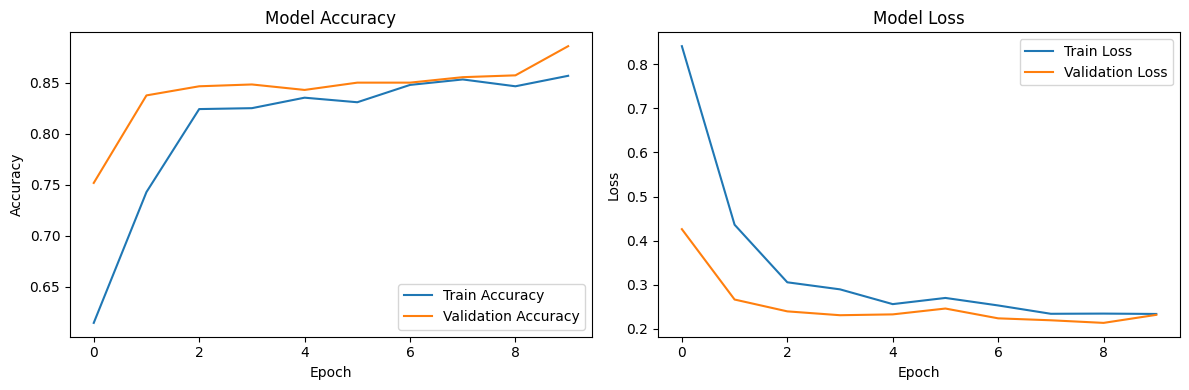

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# import os
# import numpy as np
# import geopandas as gpd
# from osgeo import gdal
# import cv2  # For resizing images
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# # Function to Load GeoTIFF Images
# def load_geotiff(tiff_path):
#     """Loads a GeoTIFF file and returns the image as a NumPy array."""
#     dataset = gdal.Open(tiff_path)
#     img = dataset.ReadAsArray()
#     return img

# # Function to Resize Images
# def resize_image(img, target_shape=(128, 128)):
#     """
#     Resizes an image to a target shape.

#     Args:
#         img (np.array): Input image.
#         target_shape (tuple): Desired (height, width).

#     Returns:
#         np.array: Resized image.
#     """
#     resized_img = cv2.resize(img, target_shape, interpolation=cv2.INTER_AREA)
#     if len(resized_img.shape) == 2:  # If grayscale, add a channel dimension
#         resized_img = np.expand_dims(resized_img, axis=-1)
#     return resized_img

# # Function to Process the Dataset
# def process_data(image_folder, label_folder, target_shape=(128, 128)):
#     """
#     Processes the dataset by linking GeoJSON files to GeoTIFF images based on their naming convention.

#     Args:
#         image_folder (str): Path to the folder containing GeoTIFF images grouped into subfolders.
#         label_folder (str): Path to the folder containing GeoJSON files.
#         target_shape (tuple): Target shape for resized images.

#     Returns:
#         tuple: A tuple containing NumPy arrays of images and labels.
#     """
#     images, labels = [], []

#     for label_file in os.listdir(label_folder):
#         if label_file.endswith('.geojson'):
#             print(f"Processing label file: {label_file}")

#             # Parse GeoJSON file
#             label_path = os.path.join(label_folder, label_file)
#             geojson = gpd.read_file(label_path)

#             # Extract relevant parts from the label file name
#             parts = label_file.split('_')
#             sensor_type = parts[0]  # 's1' or 's2'
#             digit = parts[2]
#             date = "_".join(parts[3:6])  # 'year_month_date'

#             # Ensure 'FLOODING' column exists
#             if 'FLOODING' in geojson.columns:
#                 flooding = geojson.loc[0, 'FLOODING']  # Extract flooding label
#             else:
#                 print(f"'FLOODING' column not found in {label_file}")
#                 continue

#             # Locate the matching image folder
#             folder_name = f"{sensor_type}_source_{digit}_{date}"
#             image_dir = os.path.join(image_folder, digit)

#             if os.path.exists(image_dir):
#                 print(f"Found matching folder for label file: {folder_name}")
#                 for tiff_file in os.listdir(image_dir):
#                     if folder_name in tiff_file and tiff_file.endswith('.tif'):
#                         tiff_path = os.path.join(image_dir, tiff_file)
#                         print(f"Loading image: {tiff_path}")
#                         img = load_geotiff(tiff_path)

#                         # Resize image
#                         resized_img = resize_image(img, target_shape)

#                         images.append(resized_img)
#                         labels.append(1 if flooding else 0)
#             else:
#                 print(f"No matching folder found for label file: {folder_name}")

#     # Convert lists to NumPy arrays
#     if len(images) > 0:
#         X = np.stack(images, axis=0)  # Stack images into a 4D array
#     else:
#         X = np.array([])

#     y = np.array(labels)
#     return X, y

# # Paths to the Folders (Update these paths)
# image_folder = "/content/drive/MyDrive/train/images"  # Replace with your images folder path
# label_folder = "/content/drive/MyDrive/train/labels"  # Replace with your labels folder path

# # Process the Dataset
# X, y = process_data(image_folder, label_folder)

# # Check the shape of the dataset
# print("Shape of X:", X.shape)  # Expected: (num_samples, target_height, target_width, channels)
# print("Shape of y:", y.shape)  # Expected: (num_samples,)

Processing label file: s1_labels_0001_2018_12_23_labels.geojson
Found matching folder for label file: s1_source_0001_2018_12_23
Loading image: /content/drive/MyDrive/train/images/0001/s1_source_0001_2018_12_23_VH_VH.tif
Loading image: /content/drive/MyDrive/train/images/0001/s1_source_0001_2018_12_23_VV_VV.tif
Processing label file: s1_labels_0001_2019_01_04_labels.geojson
Found matching folder for label file: s1_source_0001_2019_01_04
Loading image: /content/drive/MyDrive/train/images/0001/s1_source_0001_2019_01_04_VH_VH.tif
Loading image: /content/drive/MyDrive/train/images/0001/s1_source_0001_2019_01_04_VV_VV.tif
Processing label file: s1_labels_0004_2018_12_16_labels.geojson
Found matching folder for label file: s1_source_0004_2018_12_16
Loading image: /content/drive/MyDrive/train/images/0004/s1_source_0004_2018_12_16_VV_VV.tif
Loading image: /content/drive/MyDrive/train/images/0004/s1_source_0004_2018_12_16_VH_VH.tif
Processing label file: s1_labels_0001_2019_01_16_labels.geojson
